<a href="https://colab.research.google.com/github/Hassouna9/Water-Segmentaion-of-Sattalllite-Images-using-Deeplap3/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown
import gdown
!gdown --id 1vg8S73P3_uqvpT_QXFQElbJ7wh6vdIPk
!pip install rasterio

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1vg8S73P3_uqvpT_QXFQElbJ7wh6vdIPk
From (redirected): https://drive.google.com/uc?id=1vg8S73P3_uqvpT_QXFQElbJ7wh6vdIPk&confirm=t&uuid=221cc8ef-a43e-43a7-a34b-710c32fc35f5
To: /content/data-20240912T162055Z-001.zip
100% 68.6M/68.6M [00:05<00:00, 13.4MB/s]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 16.3 MB/s eta 0:00:00


In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import os
from PIL import Image
import zipfile
with zipfile.ZipFile('/content/data-20240912T162055Z-001.zip', 'r') as zip_ref:
    zip_ref.extractall()

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torch.amp

from torchvision import models
import torchvision.models.segmentation as segmentation

import matplotlib.pyplot as plt
import numpy as np


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [47]:
class SatelliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.tif')]

    def open_tiff(self, path):
        import rasterio  # Ensure rasterio is imported here
        with rasterio.open(path) as src:
            img = src.read()
            return np.moveaxis(img, 0, -1)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.tif', '.png'))

        image = self.open_tiff(img_path)
        mask = Image.open(mask_path).convert('L')  # Assuming PIL Image is imported globally

        if self.transform:
            transformed = self.transform(image=image, mask=np.array(mask))
            image = transformed['image']
            mask = transformed['mask']

        return image, mask

    def __len__(self):
        return len(self.images)

In [48]:
def create_deeplabv3(output_channels, in_channels):
    # Use a lighter backbone if possible, like ResNet50
    model = segmentation.deeplabv3_resnet50(weights=segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
    # Adjust the input and output layers accordingly
    model.backbone.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.classifier[4] = torch.nn.Conv2d(256, output_channels, kernel_size=1)
    model.aux_classifier[4] = torch.nn.Conv2d(256, output_channels, kernel_size=1)
    return model

In [40]:
def calculate_iou(preds, targets, threshold=0.3):
    """ Calculate Intersection over Union (IoU) for water class (class = 1). """
    preds = (preds > threshold).float()  # Convert predictions to binary (water class vs background)
    intersection = (preds * targets).sum()
    union = (preds + targets).sum() - intersection
    iou = intersection / (union + 1e-8)  # Add epsilon to avoid division by zero
    return iou.item()

def calculate_precision(preds, targets, threshold=0.5):
    """ Calculate Precision for water class (class = 1). """
    preds = (preds > threshold).float()
    true_positives = (preds * targets).sum()
    predicted_positives = preds.sum()
    precision = true_positives / (predicted_positives + 1e-8)
    return precision.item()

def calculate_recall(preds, targets, threshold=0.5):
    """ Calculate Recall for water class (class = 1). """
    preds = (preds > threshold).float()
    true_positives = (preds * targets).sum()
    actual_positives = targets.sum()
    recall = true_positives / (actual_positives + 1e-8)
    return recall.item()

def calculate_f1(precision, recall):
    """ Calculate F1-score from precision and recall. """
    if precision + recall == 0:
        return 0.0
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def check_accuracy(loader, model, is_validation=True, device="cuda"):
    model.eval()

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    total_iou = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    count = 0

    with torch.no_grad():  # Disable gradient calculation
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)  # Ensure mask has the same shape as the output

            # Get model predictions
            outputs = model(x)
            preds = outputs['out']  # Accessing the primary output
            preds = torch.sigmoid(preds)  # Apply sigmoid to obtain probabilities
            preds = (preds > 0.5).float()  # Convert probabilities to binary output


            # Calculate the number of correct pixels
            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

            # Calculate the Dice score
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

            # Compute metrics for each batch
            iou = calculate_iou(preds, y)
            precision = calculate_precision(preds, y)
            recall = calculate_recall(preds, y)
            f1 = calculate_f1(precision, recall)

            # Update totals for averaging later
            total_iou += iou
            total_precision += precision
            total_recall += recall
            total_f1 += f1
            count += 1

    # Calculate average metrics across all batches
    avg_iou = total_iou / count
    avg_precision = total_precision / count
    avg_recall = total_recall / count
    avg_f1 = total_f1 / count

    # Calculate accuracy as a percentage
    accuracy = num_correct / num_pixels * 100

    print(f"Got {num_correct}/{num_pixels} correct with accuracy {accuracy:.2f}%")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")

    model.train()  # Return the model to training mode if it's not the validation set

In [41]:
def define_transforms():
    # Adjust transforms to use smaller dimensions and efficient processing
    train_transform = A.Compose([
        # A.Resize(256, 256),  # Reduced from 513x513 to 256x256
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    val_transforms = A.Compose([
        # A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    return train_transform, val_transforms

In [49]:
def get_loaders(train_dir, train_maskdir, val_dir, val_maskdir, batch_size, train_transform, val_transform, num_workers=2, pin_memory=False):
    train_ds = SatelliteDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform
    )
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)

    val_ds = SatelliteDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform
    )
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader

train_transform, val_transforms = define_transforms()
train_loader, val_loader = get_loaders(
    "data/train_images/", "data/train_masks/",
    "data/val_images/", "data/val_masks/",
    8, train_transform, val_transforms,
    num_workers=2, pin_memory=False
)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


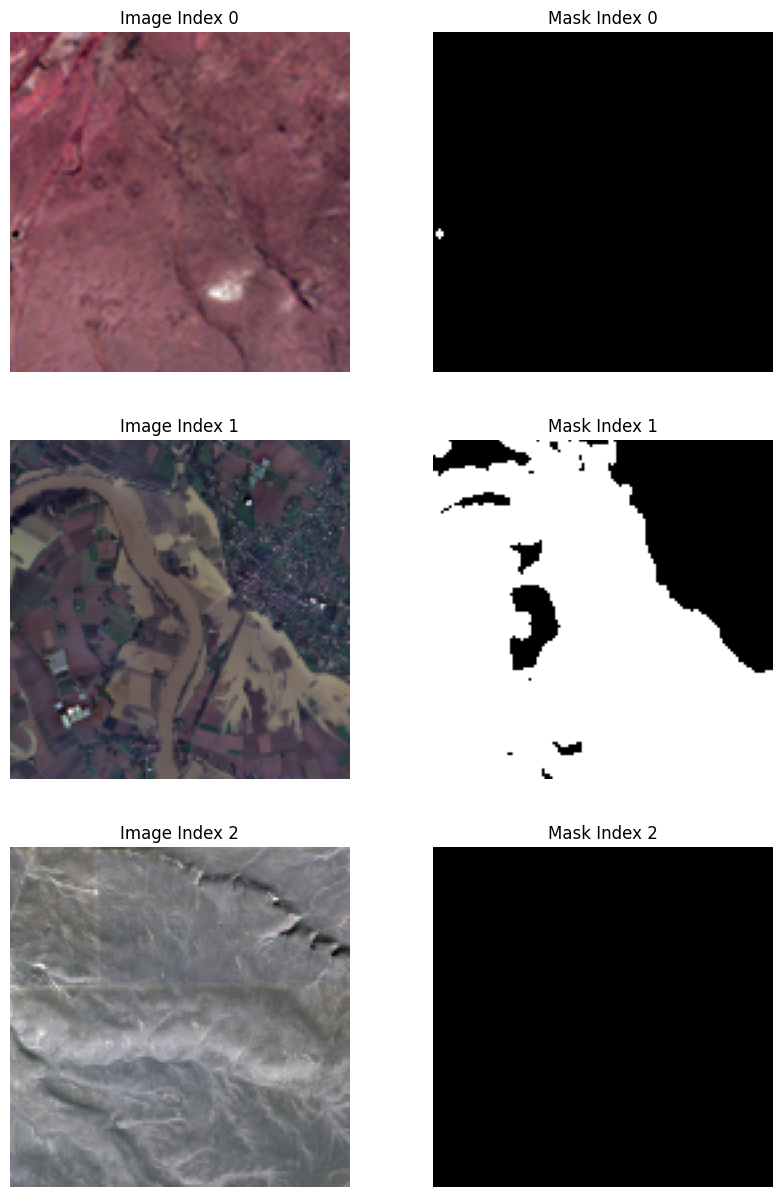

In [50]:
def visualize_image_and_mask(image_tensor, mask_tensor, indices=[0, 1, 2], red_band=3, green_band=2, blue_band=1):
    """ Visualize multiple RGB images and their corresponding masks. """


    if image_tensor.is_cuda:
        image_tensor = image_tensor.cpu()
    if mask_tensor.is_cuda:
        mask_tensor = mask_tensor.cpu()

    plt.figure(figsize=(10, len(indices) * 5))

    for i, index in enumerate(indices):
        # Image visualization setup
        red = image_tensor[index, red_band, :, :].numpy()
        green = image_tensor[index, green_band, :, :].numpy()
        blue = image_tensor[index, blue_band, :, :].numpy()

        # Normalize the bands to the [0, 1] range for visualization
        red = (red - red.min()) / (red.max() - red.min())
        green = (green - green.min()) / (green.max() - green.min())
        blue = (blue - blue.min()) / (blue.max() - blue.min())

        rgb_image = np.stack([red, green, blue], axis=-1)  # Stack the channels to create an RGB image

        plt.subplot(len(indices), 2, 2*i+1)  # Prepare subplot for the image
        plt.imshow(rgb_image)
        plt.title(f"Image Index {index}")
        plt.axis('off')

        if mask_tensor.ndim == 4:
            mask = mask_tensor[index, 0, :, :].numpy()
        else:
            mask = mask_tensor[index, :, :].numpy()

        plt.subplot(len(indices), 2, 2*i+2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask Index {index}")
        plt.axis('off')

    plt.show()


first_batch_images, first_batch_masks = next(iter(train_loader))

visualize_image_and_mask(first_batch_images, first_batch_masks, indices=[0, 1, 2])

In [51]:
def train_fn(model, dataloader, optimizer, loss_fn, device, epoch, num_epochs):
    model.train()
    loop = tqdm(dataloader, leave=True)
    for images, targets in loop:
        images = images.to(device)
        targets = targets.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        output = model(images)['out']

        if output.dtype != torch.float32:
            output = output.float()

        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {DEVICE}")

# Initialize the model
model = create_deeplabv3(output_channels=1, in_channels=12).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

# Setup for mixed precision training
scaler = torch.amp.GradScaler() if DEVICE == 'cuda' else None

num_epochs = 5
for epoch in range(num_epochs):
    train_fn(model, train_loader, optimizer, loss_fn, DEVICE, epoch, num_epochs)
    check_accuracy(val_loader, model, device=DEVICE)

Running on device: cuda


  0%|          | 0/34 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Epoch [1/5]: 100%|██████████| 34/34 [00:06<00:00,  5.15it/s, loss=0.351]
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity 

Got 506353/589824 correct with accuracy 85.85%
Average IoU: 0.5654
Average Precision: 0.8246
Average Recall: 0.6659
Average F1 Score: 0.7009


  0%|          | 0/34 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Epoch [2/5]: 100%|██████████| 34/34 [00:06<00:00,  4.95it/s, loss=0.283]
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity 

Got 507465/589824 correct with accuracy 86.04%
Average IoU: 0.6318
Average Precision: 0.7225
Average Recall: 0.8359
Average F1 Score: 0.7711


  0%|          | 0/34 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Epoch [3/5]: 100%|██████████| 34/34 [00:06<00:00,  5.20it/s, loss=0.407]
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity 

Got 480697/589824 correct with accuracy 81.50%
Average IoU: 0.5435
Average Precision: 0.6814
Average Recall: 0.7114
Average F1 Score: 0.6882


  0%|          | 0/34 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Epoch [4/5]: 100%|██████████| 34/34 [00:06<00:00,  4.93it/s, loss=0.615]
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity 

Got 516749/589824 correct with accuracy 87.61%
Average IoU: 0.6302
Average Precision: 0.8535
Average Recall: 0.6994
Average F1 Score: 0.7573


  0%|          | 0/34 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Epoch [5/5]: 100%|██████████| 34/34 [00:06<00:00,  5.11it/s, loss=0.349]
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity 

Got 527908/589824 correct with accuracy 89.50%
Average IoU: 0.6706
Average Precision: 0.9114
Average Recall: 0.7199
Average F1 Score: 0.7904


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


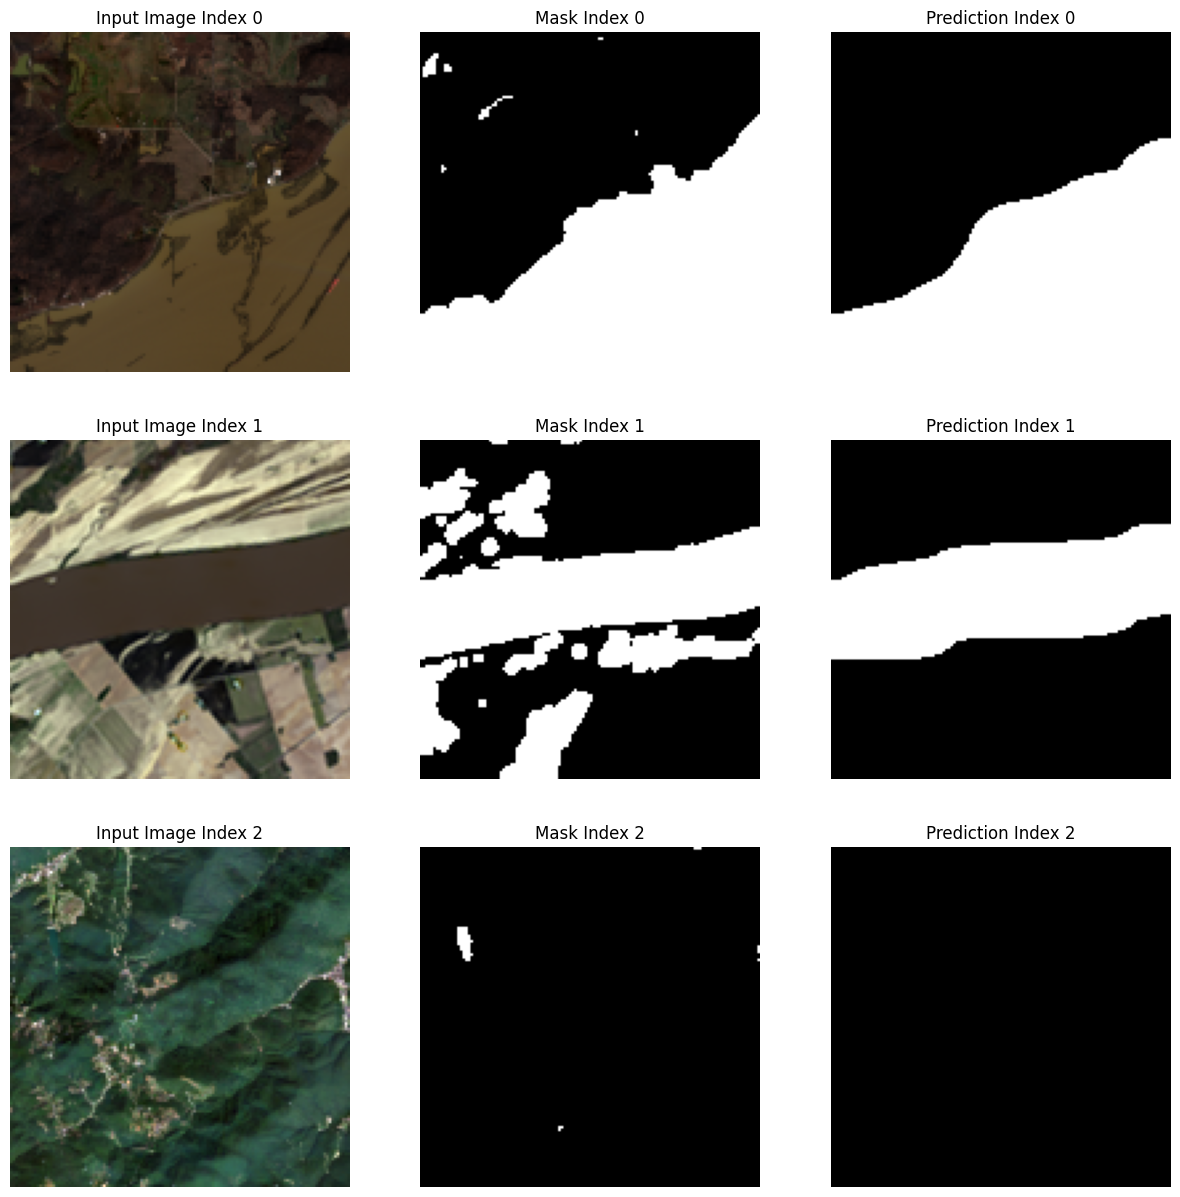

In [52]:
def visualize_input_mask_prediction(loader, model, device='cuda', indices=[0, 1, 2], red_band=3, green_band=2, blue_band=1):
    """Visualize input images, their corresponding masks, and model predictions."""
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():  # No need to track gradients
        for batch_index, (inputs, masks) in enumerate(loader):
            if batch_index == 0:  # Only process the first batch
                inputs = inputs.to(device)
                outputs = model(inputs)['out']  # Assuming model output is a dict with 'out' key
                predictions = torch.sigmoid(outputs)  # Convert logits to probabilities
                predictions = (predictions > 0.5).float()  # Threshold probabilities to create a binary mask

                # Move tensors to CPU for visualization
                inputs = inputs.cpu()
                masks = masks.cpu()
                predictions = predictions.cpu()

                plt.figure(figsize=(15, len(indices) * 5))

                for i, index in enumerate(indices):
                    # Setup for RGB image visualization from inputs
                    red = inputs[index, red_band, :, :].numpy()
                    green = inputs[index, green_band, :, :].numpy()
                    blue = inputs[index, blue_band, :, :].numpy()

                    # Normalize the channels to the [0, 1] range
                    red_normalized = (red - red.min()) / (red.max() - red.min())
                    green_normalized = (green - green.min()) / (green.max() - green.min())
                    blue_normalized = (blue - blue.min()) / (blue.max() - blue.min())

                    rgb_image = np.stack([red_normalized, green_normalized, blue_normalized], axis=-1)

                    # Input Image
                    plt.subplot(len(indices), 3, 3*i+1)
                    plt.imshow(rgb_image)
                    plt.title(f"Input Image Index {index}")
                    plt.axis('off')

                    # Ground Truth Mask
                    if masks.ndim == 4:
                        mask = masks[index, 0, :, :].numpy()
                    elif masks.ndim == 3:
                        mask = masks[index, :, :].numpy()

                    plt.subplot(len(indices), 3, 3*i+2)
                    plt.imshow(mask, cmap='gray')
                    plt.title(f"Mask Index {index}")
                    plt.axis('off')

                    # Predicted Mask
                    prediction = predictions[index, 0, :, :].numpy()
                    plt.subplot(len(indices), 3, 3*i+3)
                    plt.imshow(prediction, cmap='gray')
                    plt.title(f"Prediction Index {index}")
                    plt.axis('off')

                plt.show()
                break  # Stop after the first batch

    model.train()  # Switch back to training mode

visualize_input_mask_prediction(train_loader, model)